<a href="https://colab.research.google.com/github/vjain25/Lab7/blob/main/MA_751_Data_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Statements and Data Loading

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrix
from scipy.interpolate import splrep, BSpline, splev
import statsmodels.api as sm

In [6]:
# Step 1: Read data from the text file into a Pandas DataFrame
data = pd.read_csv('Ozone.txt', sep='\s+')
X = data[['radiation', 'temperature', 'wind']]
ozone = np.array(data['ozone'])
radiation  = np.array(data['radiation'])
temperature = np.array(data['temperature'])
wind = np.array(data['wind'])

In [7]:
# Extract Unique Values of Radiation

radiation_unique = np.unique(radiation)
temperature_unique = np.unique(temperature)
wind_unique = np.unique(wind)

In [8]:
# Reshape predictee for matrix multiplications
ozone = ozone.reshape(111,1)

## Part A – Natural Splines

First, we will expand our feature space by considering natural splines with five knots that are spaced at equal (1/6) percentiles of the data. After that, we will combine all the covariates together and run OLS on them to attain our coefficients. Note, that we will have to exclude the constant term from each spline in order to make the covariate matrix full rank and we will just add the constant term at the end.

In [20]:
def dk(x, xi_k, xi_K): # define d_k from textbook
    return (max(0, x-xi_k)**3 - max(0, x-xi_K)**3) / (xi_K-xi_k)

# now define the spline calculator given x and 5 knots
def nc_spliner(x, xi1, xi2, xi3, xi4, xi5):
    X = np.zeros(shape=(x.shape[0], 5))
    for i in range(X.shape[0]):
        X[i, 0] = 1
        X[i, 1] = x[i]
        X[i, 2] = dk(x[i], xi1, xi5) - dk(x[i], xi4, xi5)
        X[i, 3] = dk(x[i], xi2, xi5) - dk(x[i], xi4, xi5)
        X[i, 4] = dk(x[i], xi3, xi5) - dk(x[i], xi4, xi5)
    return X

In [21]:
#Calculate the natural spline representation for the three predictors

natural_radiation = nc_spliner(radiation, np.quantile(radiation, 1/6), np.quantile(radiation, 2/6), np.quantile(radiation, 3/6), np.quantile(radiation, 4/6), np.quantile(radiation, 5/6))[:,1:].reshape(-1, 4)
natural_temperature = nc_spliner(temperature, np.quantile(temperature, 1/6), np.quantile(temperature, 2/6), np.quantile(temperature, 3/6), np.quantile(temperature, 4/6), np.quantile(temperature, 5/6))[:,1:].reshape(-1, 4)
natural_wind = nc_spliner(wind, np.quantile(wind, 1/6), np.quantile(wind, 2/6), np.quantile(wind, 3/6), np.quantile(wind, 4/6), np.quantile(wind, 5/6))[:,1:].reshape(-1, 4)

In [22]:
# Do the same for arrays that have the unique values for each of them

natural_radiation_unique = nc_spliner(radiation_unique, np.quantile(radiation, 1/6), np.quantile(radiation, 2/6), np.quantile(radiation, 3/6), np.quantile(radiation, 4/6), np.quantile(radiation, 5/6))[:,1:].reshape(-1, 4)
natural_temperature_unique = nc_spliner(temperature_unique, np.quantile(temperature, 1/6), np.quantile(temperature, 2/6), np.quantile(temperature, 3/6), np.quantile(temperature, 4/6), np.quantile(temperature, 5/6))[:,1:].reshape(-1, 4)
natural_wind_unique = nc_spliner(wind_unique, np.quantile(wind, 1/6), np.quantile(wind, 2/6), np.quantile(wind, 3/6), np.quantile(wind, 4/6), np.quantile(wind, 5/6))[:,1:].reshape(-1, 4)

In [23]:
# concatenature the predictor splines into our grand predictor matrix
X = np.concatenate([natural_radiation, natural_temperature, natural_wind], axis = 1)

In [24]:
# this function takes in the predictor matrix X and the predictee y

def Part_A(X, y):

    X_new = sm.add_constant(X) # add the constant term
    J = np.linalg.inv(X_new.T @ X_new) @ X_new.T # define OLS transformation
    H = X_new @ J # find the projector matrix
    params = J @ y # estimate parameters
    y_pred = H @ y # find the fitted values
    y_var = np.var(y) # find the variance of y a.k.a sigma^2
    param_var = y_var * J @ J.T # find the variance of the parameters


    # each of the next three blocks plot the part of ozone predicted
    # by each of the covariates. Note that since we excluded the constant
    # term from each of the splines, the curves will be shifted down thus.
    # We also included error bars.

    rad_est = (natural_radiation_unique@params[1:5]).reshape(93,)
    plt.plot(radiation, ozone, 'o', radiation_unique, rad_est)
    variance_radiation = natural_radiation_unique @ param_var[1:5, 1:5] @ natural_radiation_unique.T
    rad_err = np.sqrt(np.diag(variance_radiation))
    plt.fill_between(radiation_unique, rad_est - rad_err, rad_est + rad_err, alpha = 0.2, color = "red")
    plt.xlabel('Radiation')
    plt.ylabel(r'$\hat{f}(radiation)$')
    plt.title('Natural Splines – Radiation Component')
    plt.show()


    temp_est = (natural_temperature_unique @ params[5:9]).reshape(39,)
    plt.plot(temperature, ozone, 'o', temperature_unique, temp_est)
    variance_temperature = natural_temperature_unique @ param_var[5:9, 5:9] @ natural_temperature_unique.T
    temp_err = np.sqrt(np.diag(variance_temperature))
    plt.fill_between(temperature_unique, temp_est - temp_err, temp_est + temp_err, alpha = 0.2, color = "red")
    plt.xlabel('Temperature')
    plt.ylabel(r'$\hat{f}(temperature)$')
    plt.title('Natural Splines – Temperature Component')
    plt.show()


    wind_est = (natural_wind_unique@params[9:13]).reshape(-1,)
    plt.plot(wind, ozone, 'o', wind_unique, wind_est)
    variance_wind = natural_wind_unique @ param_var[9:13, 9:13] @ natural_wind_unique.T
    wind_err = np.sqrt(np.diag(variance_wind))
    plt.fill_between(wind_unique, wind_est - wind_err, wind_est + wind_err, alpha = 0.2, color = "red")
    plt.xlabel('Wind')
    plt.ylabel(r'$\hat{f}(wind)$')
    plt.title('Natural Splines – Wind Component')
    plt.show()




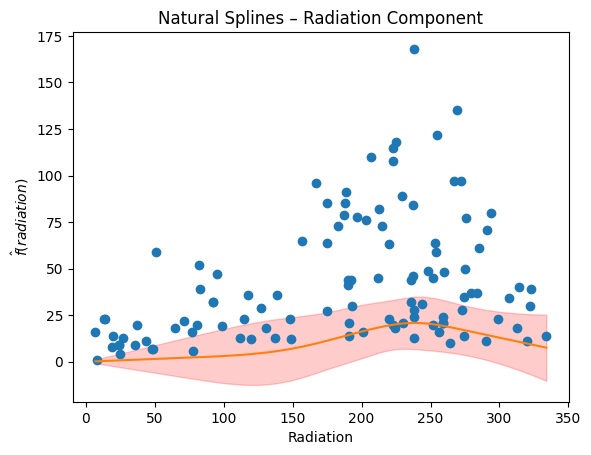

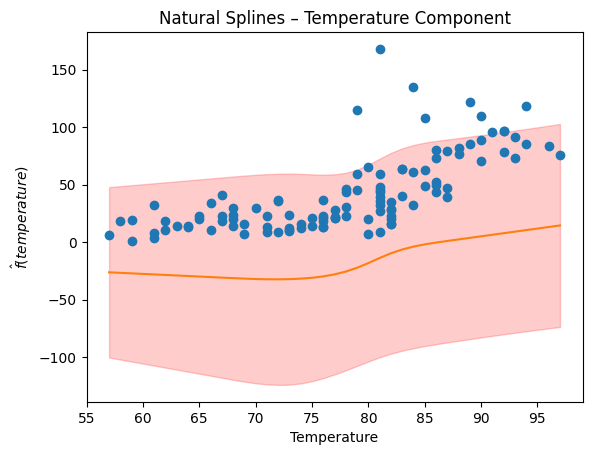

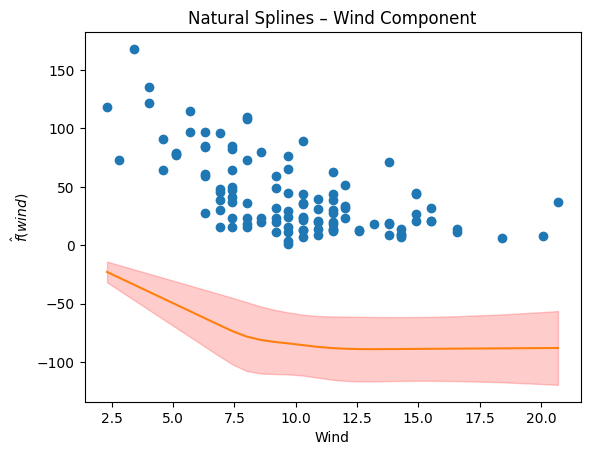

In [25]:
Part_A(X, ozone) # run it on our data

As we can see, the natural splines are quite smooth and capture the general curves and correlations in the data. Once again, since we excluded the constant term (to make the covariates linearly independent), the fitted curves are shifted down by a certain constant. Clearly, natural splines are a very powerful method of predicting and fitting values. Next we try smoothing splines!

## Part B – Smoothing Splines

We will use scipy's in built tools to implement the smoothing splines. Note that since we are running the analysis univariately, we will have to jitter the values of the predictors since they have duplicates when considered on their own. Then, we will try fitting smoothing splines with different smoothing parameters and plot the results.

In [26]:
np.random.seed(42) # set seed to maintain reproducibility

In [27]:
# this function takes in x that contains no duplicates
# and the predictee y as well as the range of lambdas called s_range
# where a bigger s corresponds with higher smoothness. Finally,
# xlabel is the name of the method

def smooth_spline(x, y, s_range, xlabel):

    sorted_indices = np.argsort(x) # sort the arrays based on x
    x_sorted, y_sorted = x[sorted_indices], y[sorted_indices]

    for s in s_range: # try all the s values and plot the change

        plt.clf()
        spline = splrep(x_sorted, y_sorted, s=s)
        plt.plot(x_sorted, y_sorted, 'o', x_sorted, splev(x_sorted, spline))
        plt.xlabel(xlabel)
        plt.ylabel('Ozone')
        plt.title(f'Smoothing Spline with Smoothing Parameter s= {s:.2f}')
        plt.show()



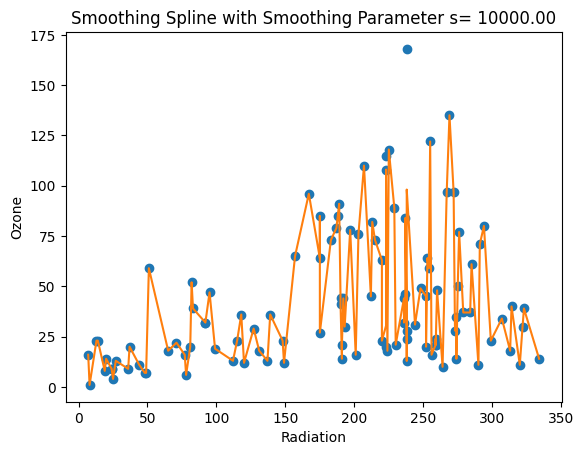

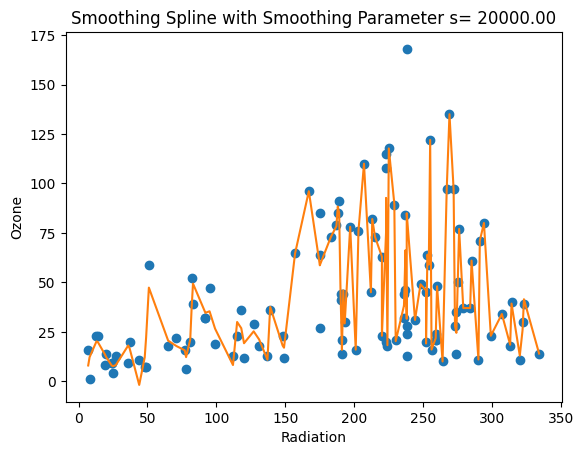

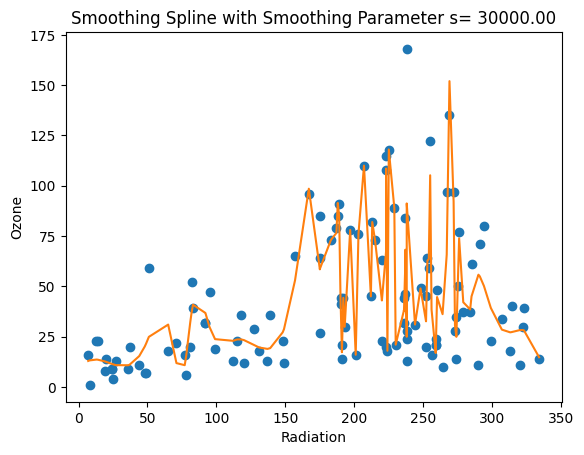

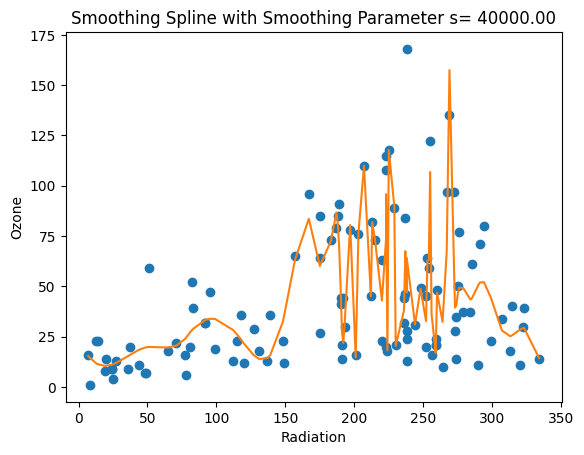

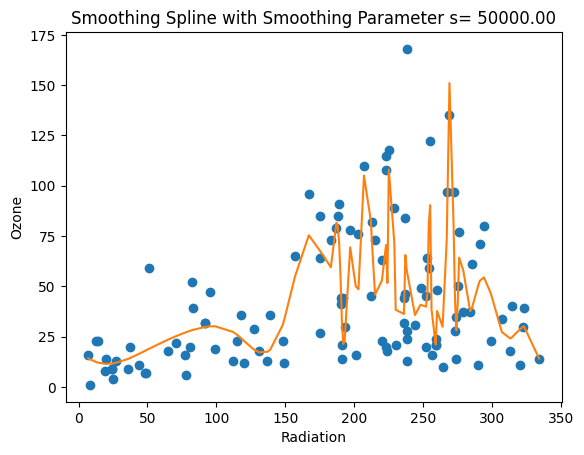

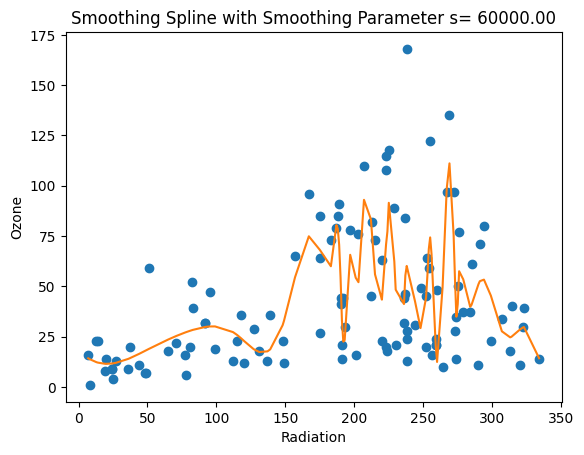

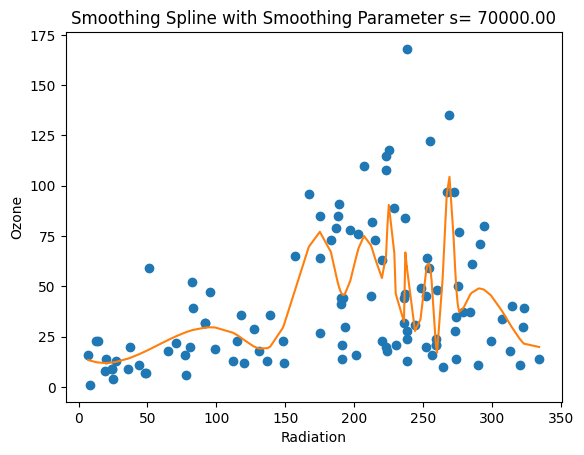

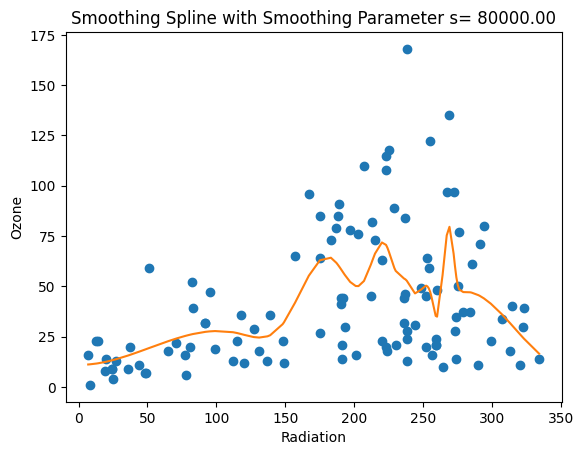

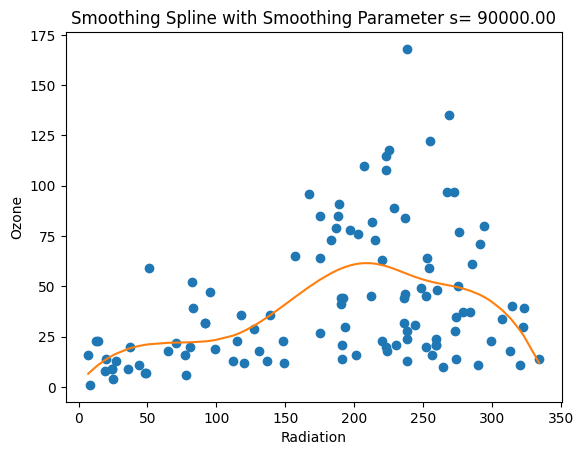

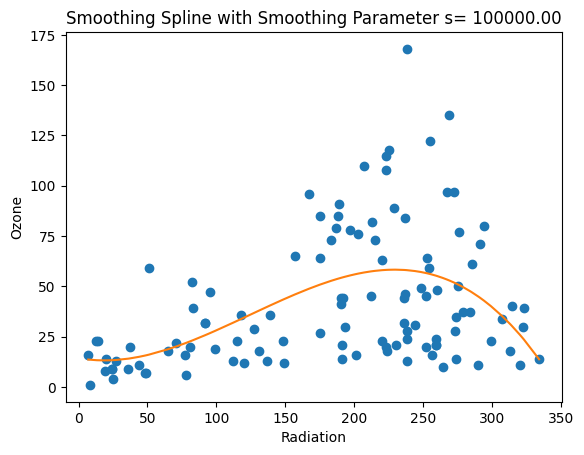

In [28]:
# we first jitter the radiation to separate duplicates and then pass into functions
jittered_radiation = radiation + np.random.uniform(low = -0.001, high = 0.001, size = radiation.shape)
smooth_spline(jittered_radiation, ozone, np.linspace(1e4, 1e5, num=10), 'Radiation')

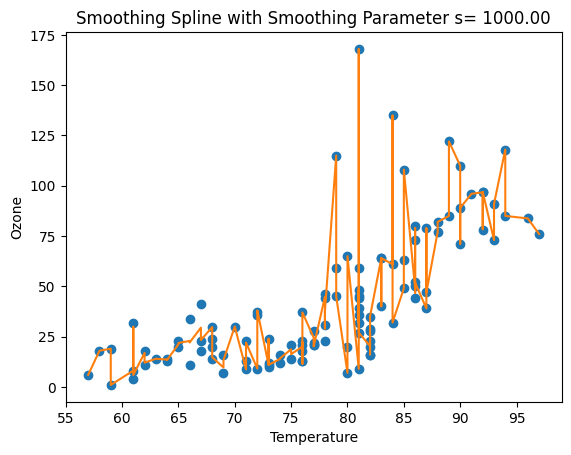

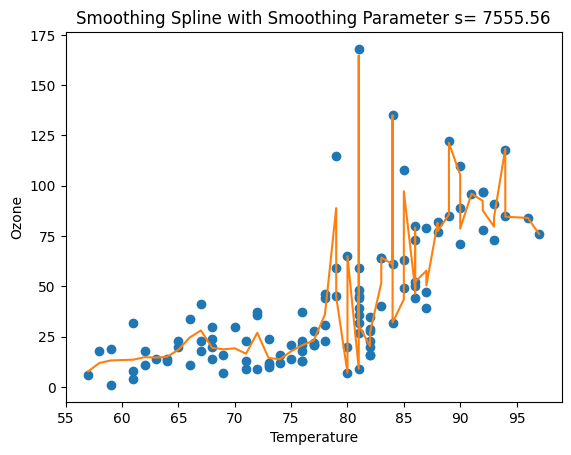

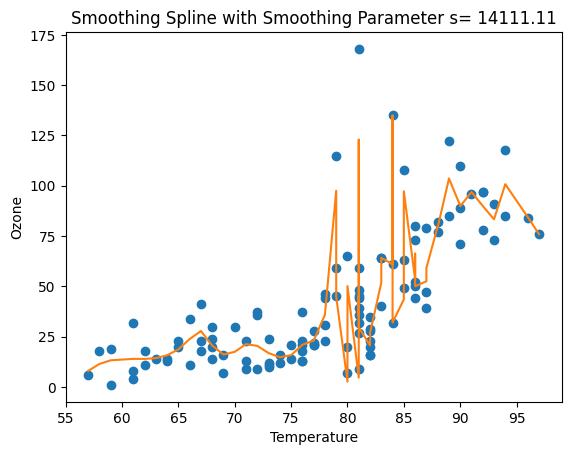

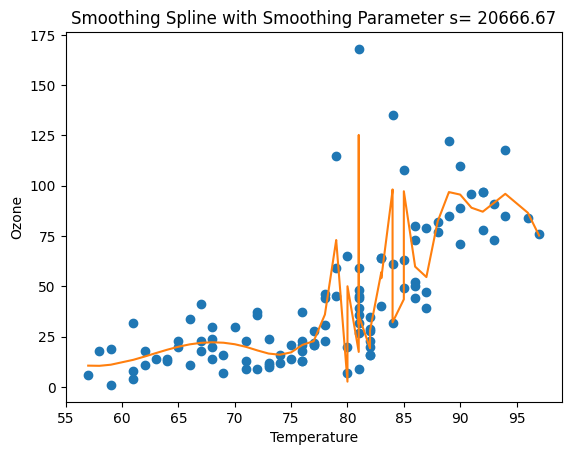

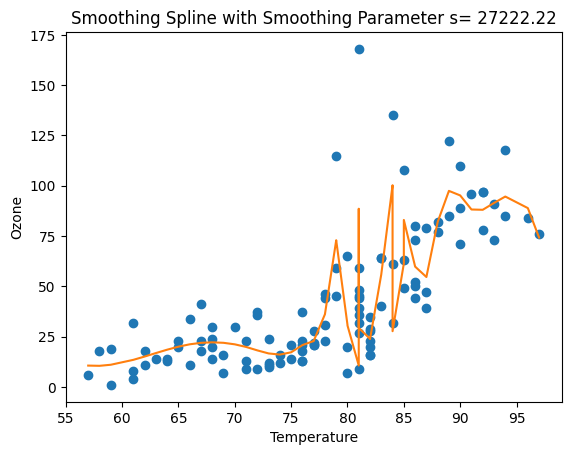

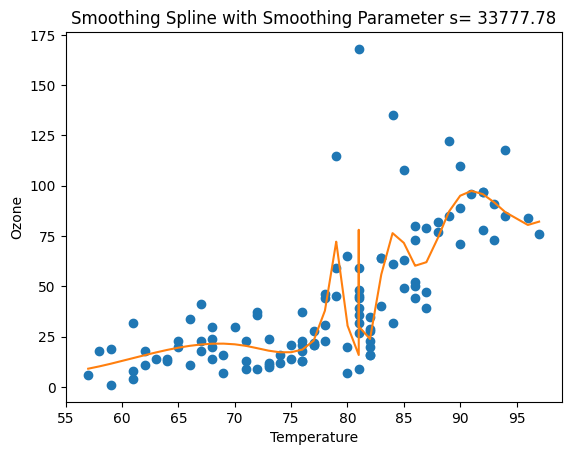

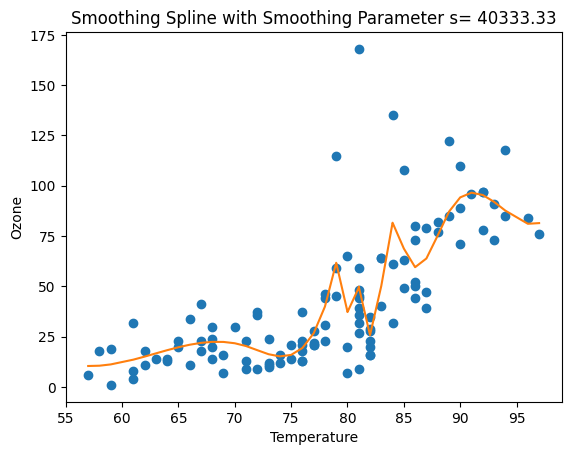

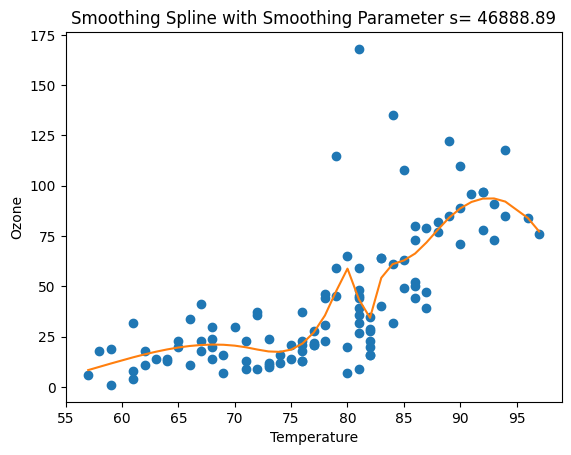

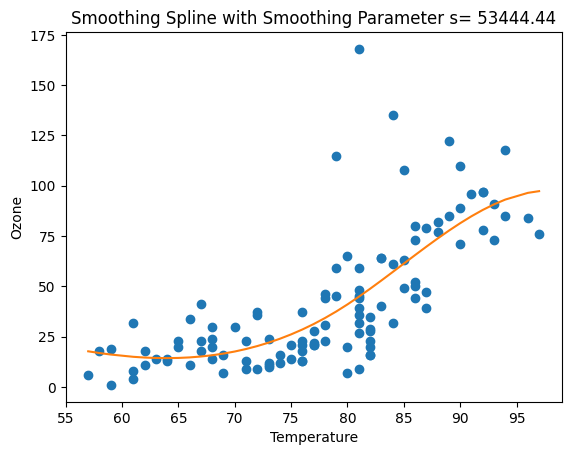

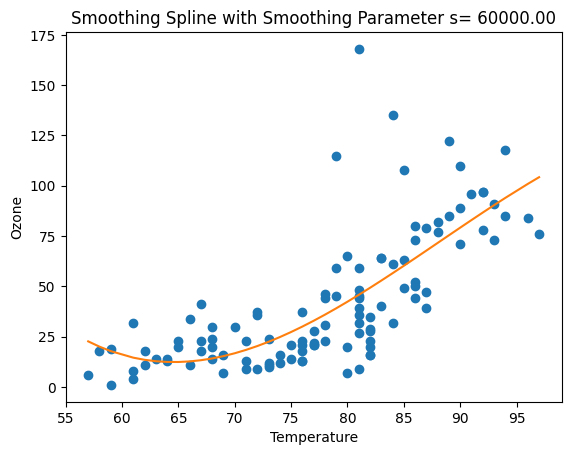

In [29]:
# same as above but for temperature
jittered_temperature = temperature + np.random.uniform(low = -0.001, high = 0.001, size = temperature.shape)
smooth_spline(jittered_temperature, ozone, np.linspace(1e3, 6e4, num=10), 'Temperature')

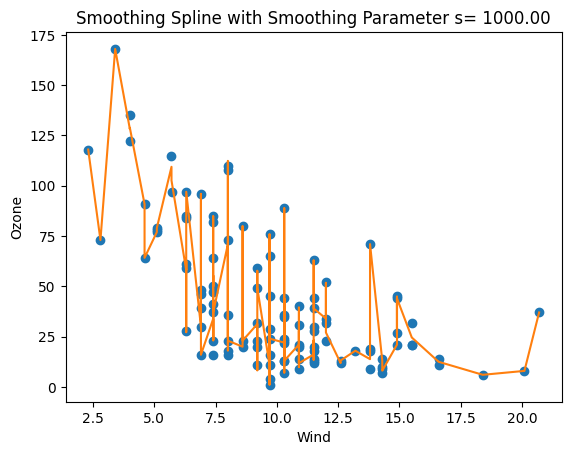

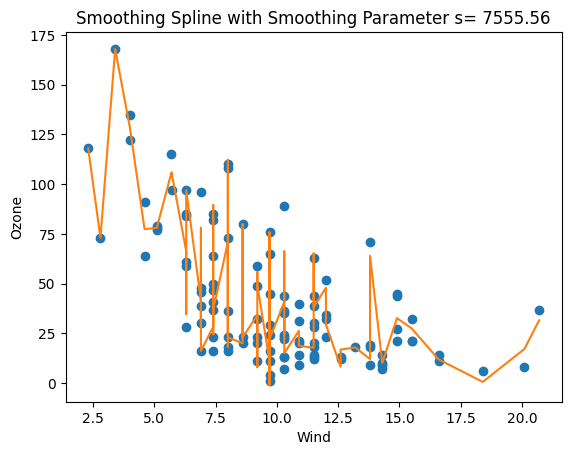

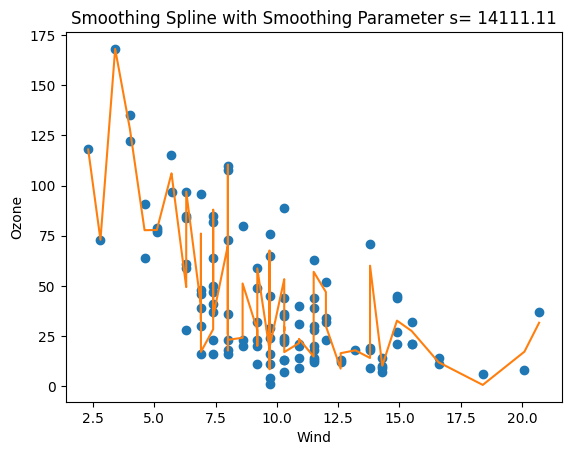

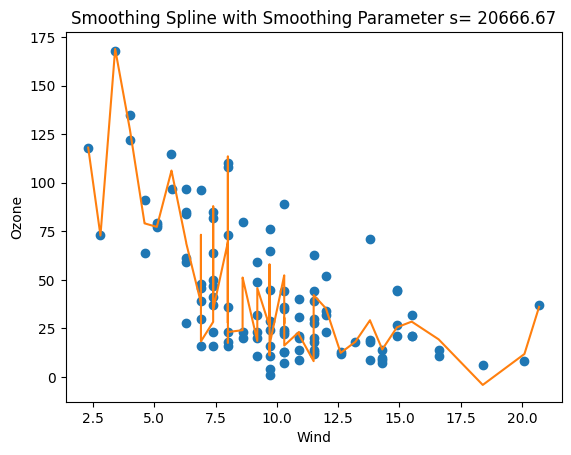

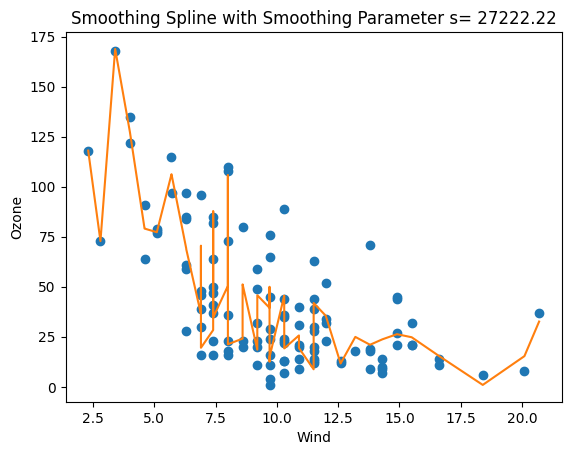

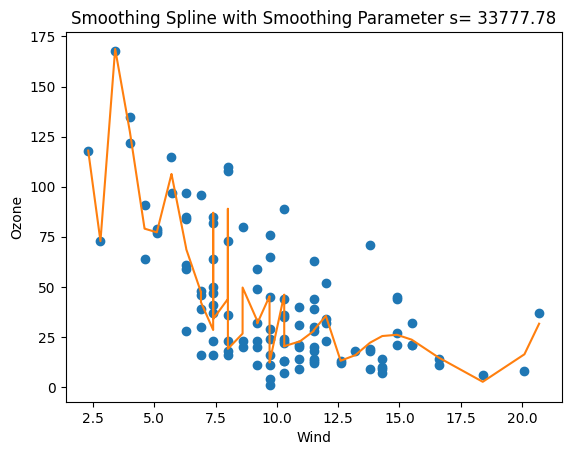

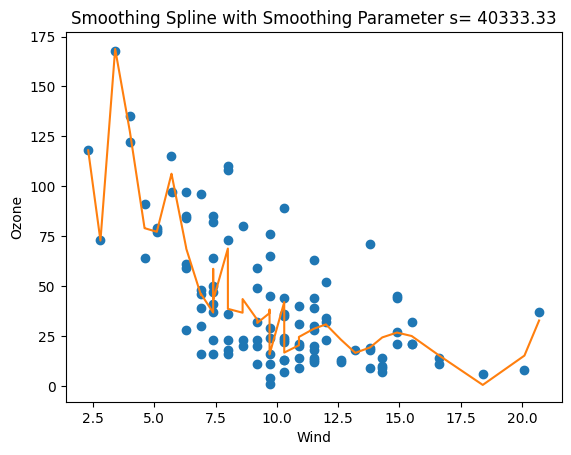

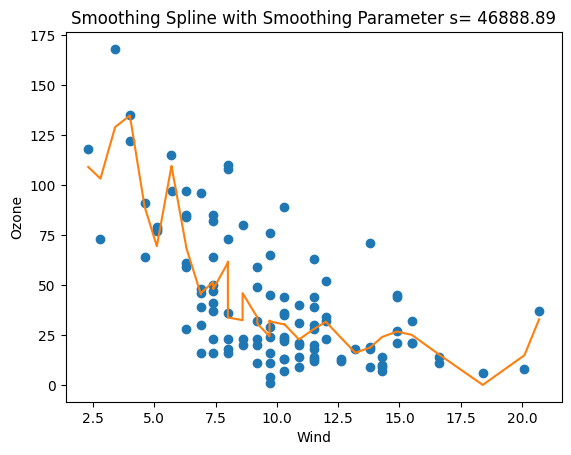

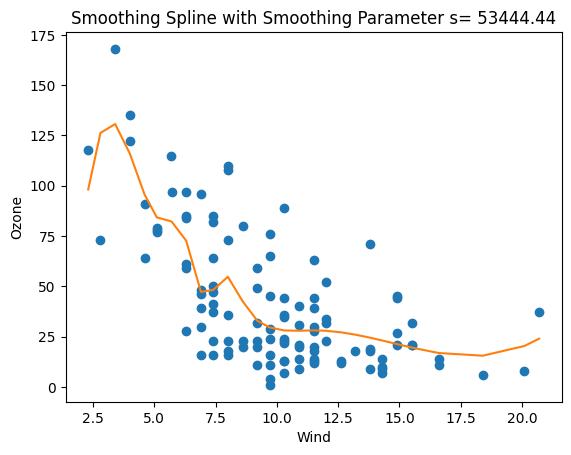

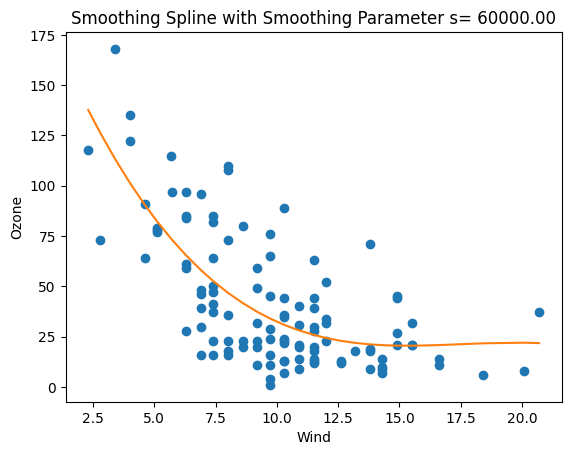

In [30]:
# same as above but for wind
jittered_wind = wind + np.random.uniform(low = -0.001, high = 0.001, size = wind.shape)
smooth_spline(jittered_wind, ozone, np.linspace(1e3, 6e4, num=10), 'Wind')

Here, we use scipy's in-built smoothing splines functions and we can clearly see how having knots at each of the training points gives us a lot of control of how our function looks. With that being said, we see the importance of the smoothing parameter that allows us to keep the function from being too jagged or too smooth. We see that there is a strong parallel in the functions found the natural splines and the smoothing splines counterparts. This of course reflects the similar underlying theory, but the additional control from the smoothing splines showcases its versatility in the domain.